In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import keras.backend as K

from keras.layers import Input, Dense
from keras.models import Sequential, Model

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

Using TensorFlow backend.
/Users/tiao/.virtualenvs/anmoku/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
'TensorFlow version: ' + K.tf.__version__

'TensorFlow version: 1.4.0'

### Constants

In [4]:
n_samples = 100
n_features = 2
n_classes = 2
seed = 42
rng = np.random.RandomState(seed)

## Toy Dataset ("Gaussian blobs")

In [5]:
x_test, y_test = make_blobs(n_samples=n_samples, centers=n_classes, random_state=rng)

In [6]:
# class labels are balanced
np.sum(y_test)

50

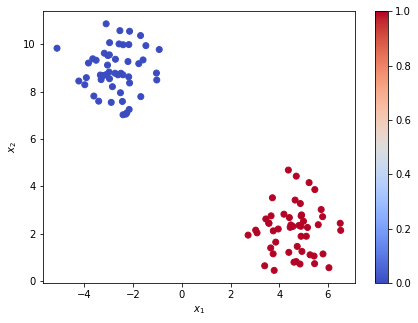

In [7]:
fig, ax = plt.subplots(figsize=(7, 5))

cb = ax.scatter(*x_test.T, c=y_test, cmap='coolwarm')
fig.colorbar(cb, ax=ax)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

## Typical Model Specification for Logistic Regression

In [8]:
classifier = Sequential([
    Dense(16, input_dim=n_features, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
classifier.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [9]:
loss = classifier.evaluate(x_test, y_test)
loss

100/100 [==============================] - 0s 1ms/step


0.66595284819602962

## Alternative Specification

An alternative specification isolates the positive and negative samples and explicitly requires an input for each class. The loss that is optimized is then the sum of the binary cross-entropy losses for each class. Since we fix the corresponding target labels to be all ones or zeros accordingly, the binary cross-entropy losses for each class both result in one of the complementary terms, and averaging them would result in the usual binary cross-entropy loss on all samples with their corresponding labels.

This trick is crucial for many model specifications in [keras-adversarial](https://github.com/bstriner/keras-adversarial).

In [10]:
pos = Input(shape=(n_features,))
neg = Input(shape=(n_features,))

# make use of the classifier defined earlier
y_pred_pos = classifier(pos)
y_pred_neg = classifier(neg)

# define a multi-input, multi-output model
classifier_alt = Model([pos, neg], [y_pred_pos, y_pred_neg])
classifier_alt.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [11]:
losses = classifier_alt.evaluate(
    [
        x_test[y_test == 1], 
        x_test[y_test == 0]
    ], 
    [
        np.ones(n_samples // 2), 
        np.zeros(n_samples // 2)
    ]
)
losses

50/50 [==============================] - 0s 1ms/step


[1.3319057083129884, 1.0514429426193237, 0.28046274423599243]

The loss that actually gets optimized is the first value above, the sum of the subsequent values. The mean of them is the required binary cross-entropy loss.

In [12]:
.5 * losses[0]

0.66595285415649419

In [13]:
# alternatively
np.mean(losses[1:])

0.66595284342765804

In [14]:
np.allclose(loss, np.mean(losses[1:]))

True